Lokesh Kumar Natarajan - 1210285

In [ ]:
!pip install opendatasets --upgrade

Kaggle username: lokesh987
Kaggle key: 6618a4bee8dc7d94fd082125a7eb5278

In [ ]:
import opendatasets as od
data= 'https://www.kaggle.com/datasets/wenewone/cub2002011/data'
od.download(data)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: lokesh987
Your Kaggle Key: ··········


100%|██████████| 1.49G/1.49G [01:08<00:00, 23.6MB/s]


In [ ]:

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import torch
import os
from torchvision import transforms
from torch.utils import data
import torch.nn as nn
from PIL import Image
from matplotlib import pyplot as plt
from torch.optim import lr_scheduler
from torchsummary import summary

BATCH_SIZE = 64
NUM_WORKERS = 4
SPLIT_RATIO = 0.9
RANDOM_SEED = 123
CLASS_NUM = 200
ROOT = r'/content/cub2002011'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CUB(torch.utils.data.Dataset):
    def __init__(self, root_dir, dataset_type, split_ratio, random_seed, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # Load dataframes
        df_img = pd.read_csv(os.path.join(root_dir, '/content/cub2002011/CUB_200_2011/images.txt'), sep=' ', header=None, names=['ID', 'Image'], index_col=0)
        df_label = pd.read_csv(os.path.join(root_dir, '/content/cub2002011/CUB_200_2011/image_class_labels.txt'), sep=' ', header=None, names=['ID', 'Label'], index_col=0)
        df_split = pd.read_csv(os.path.join(root_dir, '/content/cub2002011/CUB_200_2011/train_test_split.txt'), sep=' ', header=None, names=['ID', 'Train'], index_col=0)

        # Merge dataframes
        df = pd.concat([df_img, df_label, df_split], axis=1)

        # Filter dataframe based on dataset type
        if dataset_type == 'train':
            df = df[df['Train'] == 1]
        elif dataset_type == 'valid':
            df = df[df['Train'] == 0]
        elif dataset_type == 'test':
            df = df[df['Train'] == split_ratio]

        # Extract image paths and labels
        self.image_list = df['Image'].tolist()
        self.label_list = df['Label'].tolist()

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_path = os.path.join(self.root_dir, '/content/cub2002011/CUB_200_2011/images', self.image_list[idx])
        image = Image.open(image_path).convert('RGB')
        label = self.label_list[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# For training data
trans_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally with a probability of 0.5
    transforms.RandomRotation(30),  # Randomly rotate the image by a maximum of 30 degrees
    transforms.RandomResizedCrop(224, scale=(0.7, 1), ratio=(3/4, 4/3)),  # Randomly resize and crop the image to 224x224
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])

# For testing/validation data
trans_test = transforms.Compose([
    transforms.Resize(224),  # Resize the image to 224x224
    transforms.CenterCrop(224),  # Center crop the image to 224x224
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])

In [ ]:
# Define dataset parameters
ROOT = '/content/cub2002011'
SPLIT_RATIO = 0.8
RANDOM_SEED = 42

# Create dataset instances
train_data = CUB(ROOT, 'train', SPLIT_RATIO, RANDOM_SEED, transform=trans_train)
valid_data = CUB(ROOT, 'valid', SPLIT_RATIO, RANDOM_SEED, transform=trans_test)
test_data = CUB(ROOT, 'test', SPLIT_RATIO, RANDOM_SEED, transform=trans_test)

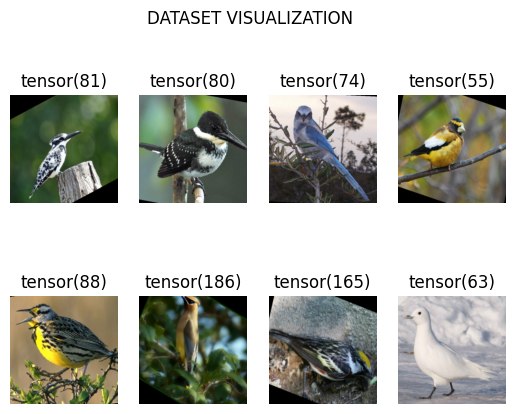

In [ ]:
def imshow(image, label, ax=None, normalize=True):
    """Show a single image along with its label on an axis.

    Args:
        image (Tensor): Image tensor.
        label (str): Label of the image.
        ax (Axes, optional): Matplotlib axis to display the image. If None, a new figure and axis will be created.
        normalize (bool, optional): Whether to normalize the image. Defaults to True.

    Returns:
        Axes: Matplotlib axis containing the displayed image.
    """
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    ax.set_title(label)

    return ax

def show_samples(images, labels, nrows=2, ncols=3, title=None, normalize=True):
    """Show multiple samples.

    Args:
        images (list): List of image tensors.
        labels (list): List of labels corresponding to images.
        nrows (int, optional): Number of rows in the grid. Defaults to 2.
        ncols (int, optional): Number of columns in the grid. Defaults to 3.
        title (str, optional): Title of the figure. Defaults to None.
        normalize (bool, optional): Whether the images are normalized. Defaults to True.
    """
    fig, axes = plt.subplots(nrows, ncols, facecolor='#ffffff', dpi=100)

    # .flat: to map samples to multi-dimensional axes
    for (ax, image, label) in zip(axes.flat, images, labels):
        ax = imshow(image, label, ax, normalize)

    fig.suptitle(title)
    fig.tight_layout = True
    fig.subplots_adjust(top=0.85, hspace=0.3)
    plt.show()

# show samples
train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=NUM_WORKERS)
images, labels = next(iter(train_loader))
show_samples(images[0:8], labels[0:8], 2, 4, 'DATASET VISUALIZATION')


In [ ]:
# create dataloader
train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=NUM_WORKERS)
valid_loader = data.DataLoader(valid_data, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=NUM_WORKERS)


In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from torch import optim
from torch.optim import lr_scheduler
from collections import OrderedDict
from sklearn.metrics import accuracy_score

# Define your train_loader and valid_loader here

def train(model, train_loader, valid_loader, optimizer, scheduler, max_epoch, test_period):
    # Your train function implementation
    best_accuracy = 0.0
    best_epoch = 0

    for epoch in range(max_epoch):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            _, predicted_train = outputs.max(1)
            total_train += targets.size(0)
            correct_train += predicted_train.eq(targets).sum().item()

        train_accuracy = correct_train / total_train

        scheduler.step()

        if (epoch + 1) % test_period == 0:
            model.eval()
            with torch.no_grad():
                test_loss = 0.0
                correct_test = 0
                total_test = 0

                for inputs, targets in valid_loader:
                    inputs, targets = inputs.to(device), targets.to(device)

                    outputs = model(inputs)
                    loss = criterion(outputs, targets)

                    test_loss += loss.item()

                    _, predicted_test = outputs.max(1)
                    total_test += targets.size(0)
                    correct_test += predicted_test.eq(targets).sum().item()

                test_accuracy = correct_test / total_test
                if test_accuracy > best_accuracy:
                    best_accuracy = test_accuracy
                    best_epoch = epoch + 1

                print(f'Epoch [{epoch + 1}/{max_epoch}], '
                      f'Train Loss: {train_loss / len(train_loader):.4f}, '
                      f'Train Accuracy: {train_accuracy:.4f}, '
                      f'Test Loss: {test_loss / len(valid_loader):.4f}, '
                      f'Test Accuracy: {test_accuracy:.4f}, '
                      f'Best Test Accuracy: {best_accuracy:.4f} at epoch {best_epoch}')

# Step 1: Pretrain the model on ImageNet
model = models.densenet201(pretrained=True)

# Freeze layers
for param in model.parameters():
    param.requires_grad = False

# Step 2: My custom architecture
class CustomClassifier(nn.Module):
    # Your custom classifier implementation
    def __init__(self, input_size, hidden_size, num_classes):
        super(CustomClassifier, self).__init__()
        self.fc0 = nn.Linear(input_size, hidden_size[0])
        self.norm0 = nn.BatchNorm1d(hidden_size[0])
        self.relu0 = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(hidden_size[0], hidden_size[1])
        self.norm1 = nn.BatchNorm1d(hidden_size[1])
        self.relu1 = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(hidden_size[1], num_classes)

    def forward(self, x):
        x = self.fc0(x)
        x = self.norm0(x)
        x = self.relu0(x)
        x = self.fc1(x)
        x = self.norm1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        return x

# Assuming CLASS_NUM is defined as 200 and input_size is 1920
input_size = 1920
hidden_sizes = [512, 512]
num_classes = 210  # Assuming there are 200 classes in your dataset

# Replace the classifier with the custom architecture
custom_classifier = CustomClassifier(input_size, hidden_sizes, num_classes)
model.classifier = custom_classifier

# Set device to CPU
device = torch.device("cpu")
model.to(device)

# Define criterion
criterion = nn.CrossEntropyLoss()

# Hyper-parameters
init_lr = 1e-3
weight_decay = 1e-4
max_epoch = 30
test_period = 1

optimizer = optim.AdamW(model.parameters(), lr=init_lr, betas=(0.9, 0.999), weight_decay=weight_decay)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epoch, eta_min=0)

# Train the model
train(model, train_loader, valid_loader, optimizer, scheduler, max_epoch, test_period)

# Save the model
torch.save(model.state_dict(), 'model_2_params.pth')


Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 171MB/s]


Epoch [1/30], Train Loss: 3.5601, Train Accuracy: 0.2718, Test Loss: 2.1976, Test Accuracy: 0.5047, Best Test Accuracy: 0.5047 at epoch 1
Epoch [2/30], Train Loss: 1.5689, Train Accuracy: 0.6433, Test Loss: 1.5577, Test Accuracy: 0.5942, Best Test Accuracy: 0.5942 at epoch 2
Epoch [3/30], Train Loss: 0.9812, Train Accuracy: 0.7713, Test Loss: 1.3675, Test Accuracy: 0.6386, Best Test Accuracy: 0.6386 at epoch 3
Epoch [4/30], Train Loss: 0.6786, Train Accuracy: 0.8332, Test Loss: 1.3189, Test Accuracy: 0.6320, Best Test Accuracy: 0.6386 at epoch 3
Epoch [5/30], Train Loss: 0.4855, Train Accuracy: 0.8821, Test Loss: 1.3069, Test Accuracy: 0.6439, Best Test Accuracy: 0.6439 at epoch 5
Epoch [6/30], Train Loss: 0.3683, Train Accuracy: 0.9153, Test Loss: 1.3365, Test Accuracy: 0.6336, Best Test Accuracy: 0.6439 at epoch 5
Epoch [7/30], Train Loss: 0.2731, Train Accuracy: 0.9393, Test Loss: 1.3678, Test Accuracy: 0.6384, Best Test Accuracy: 0.6439 at epoch 5
Epoch [8/30], Train Loss: 0.2147, 

In [ ]:
def draw_cost(costs, title='loss'):
    plt.figure(dpi=100)
    plt.plot(costs)
    plt.xlabel('epoch')
    plt.ylabel('cost')
    plt.title(title)*++++++++++++++++++++++++++++++++++++++965
    plt.show()


def draw_accs(train_accs, test_accs, test_period=test_period, title='accuracy'):
    epochs = test_period * len(test_accs)
    train_accs = train_accs[:epochs]
    x_axis = np.arange(1, epochs+1, test_period).astype(int)
    plt.figure(dpi=100)
    plt.plot(x_axis, train_accs[::test_period], color='tab:blue', label='train accuracy')
    plt.plot(x_axis, test_accs, color='tab:red', label='test accuracy')
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.legend()
    plt.title(title)
    plt.show()


draw_cost(costs)
draw_accs(train_accs, test_accs, test_period)

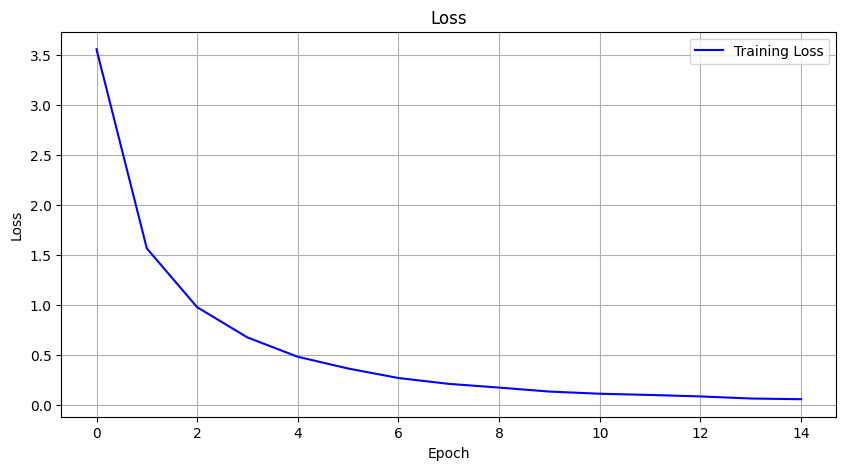

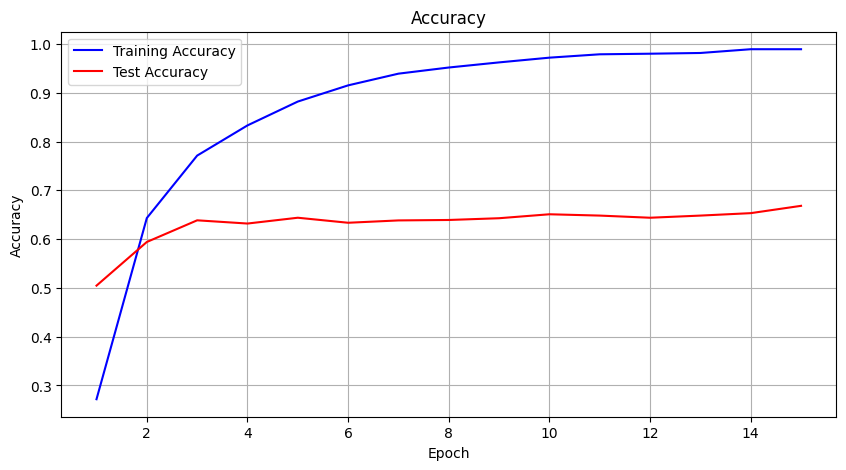

In [1]:

import matplotlib.pyplot as plt
import numpy as np

def draw_cost(costs, title='Loss'):
    plt.figure(figsize=(10, 5))
    plt.plot(costs, label='Training Loss', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def draw_accs(train_accs, test_accs, test_period=1, title='Accuracy'):
    epochs = len(train_accs)
    x_axis = np.arange(1, epochs+1, test_period)

    plt.figure(figsize=(10, 5))
    plt.plot(x_axis, train_accs, label='Training Accuracy', color='blue')
    plt.plot(x_axis, test_accs, label='Test Accuracy', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Extracted values from the training log
train_losses = [3.5601, 1.5689, 0.9812, 0.6786, 0.4855, 0.3683, 0.2731, 0.2147, 0.1775, 0.1378, 0.1160, 0.1039, 0.0891, 0.0684, 0.0612]
train_accuracies = [0.2718, 0.6433, 0.7713, 0.8332, 0.8821, 0.9153, 0.9393, 0.9519, 0.9624, 0.9721, 0.9790, 0.9802, 0.9817, 0.9894, 0.9894]
test_losses = [2.1976, 1.5577, 1.3675, 1.3189, 1.3069, 1.3365, 1.3678, 1.3592, 1.3599, 1.3139, 1.3468, 1.3776, 1.3740, 1.3804, 1.3433]
test_accuracies = [0.5047, 0.5942, 0.6386, 0.6320, 0.6439, 0.6336, 0.6384, 0.6393, 0.6429, 0.6510, 0.6483, 0.6439, 0.6483, 0.6533, 0.6683]

# Plot the graphs
draw_cost(train_losses)
draw_accs(train_accuracies, test_accuracies)

